## Hamiltonian Monte Carlo

Functions:
- Normal: returns the gaussian PDF with given point, mean and variance
- neg_log_prob: returns the neg log of the gaussian
- func: unknown function to maximize
- leapfrog_step: returns the updated parameters q1, p1
- metropolis_acceptance: calculates the ratio and returns True if the trajectory was acepted
- HMC: Produces an array of samples, of trajectories and a boolean array if the traj is accepted or not

In [63]:
import numpy as np
import random
import scipy.stats as st
import scipy.integrate as integ
import matplotlib.pyplot as plt
from tqdm import tqdm

def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma))

def func(x):
    return 0.2*normal(x, 0, 0.5) + 0.8*normal(x, 4, 0.5)

def leapfrog_step_old(q1, p1, step_size):
    dVdQ_1 = (-1*np.log(func(q1 + epsilon)) + np.log(func(q1)))/epsilon   #First gradient (ref https://www.jarad.me/courses/stat615/slides/Hierarchical/Hierarchical5.pdf)
    p1 -= step_size*dVdQ_1/2 # as potential energy increases, kinetic energy decreases, half-step
    q1 += step_size*p1 # position increases as function of momentum 
    
    dVdQ_2 = (-1*np.log(func(q1 + epsilon)) + np.log(func(q1)))/epsilon 
    p1 -= step_size*dVdQ_2/2 # second half-step "leapfrog" update to momentum 
    return q1, p1

def leapfrog_step(q1, p1, step_size, epsilon):
    A_2 = func(q1 + epsilon)
    A_1 = func(q1)
    dVdQ_1 = -(A_2 - A_1) / (epsilon * A_1)
#   dVdQ_1 = (-1*np.log(func(q1 + epsilon)) + np.log(func(q1)))/epsilon   #First gradient (ref https://www.jarad.me/courses/stat615/slides/Hierarchical/Hierarchical5.pdf)
    p1 -= step_size*dVdQ_1/2 # as potential energy increases, kinetic energy decreases, half-step
    q1 += step_size*p1 # position increases as function of momentum 

#   dVdQ_2 = (-1*np.log(func(q1 + epsilon)) + np.log(func(q1)))/epsilon 
    A_2 = func(q1 + epsilon)
    A_1 = func(q1)
    dVdQ_2 = -(A_2 - A_1) / (epsilon * A_1)
    p1 -= step_size*dVdQ_2/2 # second half-step "leapfrog" update to momentum 
    return q1, p1

def metropolis_acceptance(q0, p0, q1, p1):
    q0_nlp = func(q0)
    q1_nlp = func(q1)

    p0_nlp = normal(x=p0,mu=0,sigma=1)
    p1_nlp = normal(x=p1,mu=0,sigma=1)

    target = q1_nlp/q0_nlp # P(q1)/P(q0)
    adjustment = p1_nlp/p0_nlp # P(p1)/P(p0)
    acceptance = target*adjustment
    
    event = random.uniform(0,1)
    return event <= acceptance

def HMC(path_len=1,step_size=0.1,initial_position=1.0, epsilon = 0.01, epochs=20_000):
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    momentum_dist = st.norm(0, 1)
    samples = [initial_position]
    trajectories = []
    success = [] 
    # generate samples
    for e in tqdm(range(epochs)):
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
#         if e > 0 and success[-1]:
#             p0 = np.copy(p1)
#         else:
#             p0 = momentum_dist.rvs()
        p0 = momentum_dist.rvs()
        p1 = np.copy(p0) 
        traj = [[q0, p0]]
        
        
        # leapfrog integration 
        for s in range(steps): 
            q1, p1 = leapfrog_step(q1, p1, step_size, epsilon)
            traj.append(np.array([q1, p1]))  
        
        #flip momentum for reversibility 
        #p1 = -1*p1     
        trajectories.append(traj)
        
        #metropolis acceptance
        accepted = metropolis_acceptance(q0, p0, q1, -1*p1)
        
        #Decide acceptance or refusal
        if accepted:
            samples.append(q1)
            success.append(True)
        else:
            samples.append(q0)
            success.append(False)
    
    return np.array(samples[1:]), np.array(trajectories), np.array(success)

### Testing
Run HMC and plots histogram of ALL THE SAMPLED POINTS. Quindi se sei al punto 3 e generi 5 triettorie tutte rifiutate comunque il punto 3 compare 5 volte nella statistica dei trials, é giusto?

100%|██████████| 20000/20000 [00:06<00:00, 3059.76it/s]


Rate of accepted trajectories: 19905/20000 = 0.99525


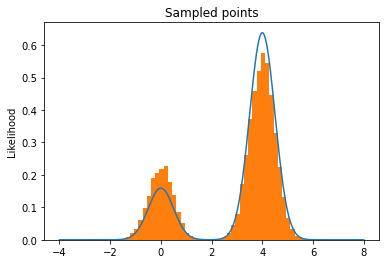

In [64]:
epochs = 20000
path_len = .8
step_size = 0.1
epsilon = 0.01

trial, trajectories, success= HMC(path_len=path_len,step_size=step_size, epsilon = epsilon, epochs = epochs)

trial = np.array(trial)
lines = np.linspace(-4,8,10_000)
normal_curve = [func(l) for l in lines]

accepted = np.sum(success)
print('Rate of accepted trajectories: {}/{} = {}'.format(accepted, epochs, accepted/epochs))
plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=50)
plt.title('Sampled points')
plt.ylabel('Likelihood')
plt.show()    

We plot only the points obtained from an accepted trajectories (so there is no over counting)

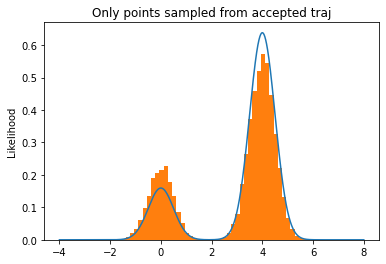

In [65]:
trial_accepted = trial[success == True]
lines = np.linspace(-4,8,10_000)
normal_curve = [func(l) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial_accepted,density=True,bins=50)
plt.title('Only points sampled from accepted traj')
plt.ylabel('Likelihood')
plt.show()   

Last 100 sampled points

(array([10.,  5.,  8., 20., 10., 21., 12.,  6.,  5.,  3.]),
 array([3.03238295, 3.25772241, 3.48306187, 3.70840133, 3.93374079,
        4.15908025, 4.38441971, 4.60975917, 4.83509863, 5.06043809,
        5.28577755]),
 <BarContainer object of 10 artists>)

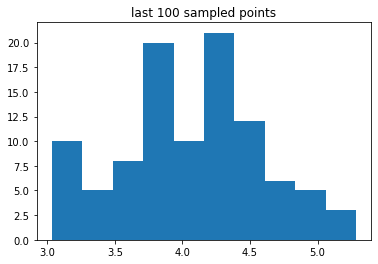

In [66]:
fig = plt.figure()
plt.title('last 100 sampled points')
plt.hist(trial[len(trial)-100:])


### Plotting
We plot the likelihood over the phase space: (q, p) to visualize the first and last trajectories.

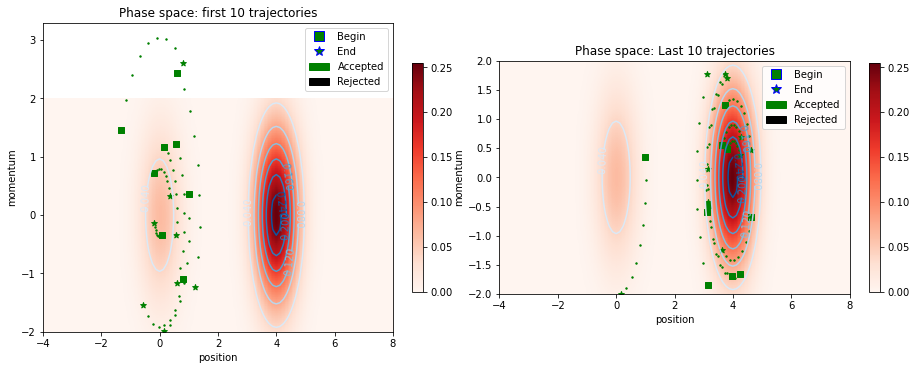

In [67]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

how_many_traj = 10

x = np.linspace(-4, 8, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z1 = func(X)
Z2 = normal(Y, 0, 1)
Z = Z1*Z2

fig, axes = plt.subplots(1, 2, figsize = (15, 9))
ax1 = axes[0]
ax2 = axes[1]

#------------ FIRST PLOT ----------------------#
ax1.set_xlabel('position')
ax1.set_ylabel('momentum')
CS = ax1.contour(X, Y, Z, cmap = 'Blues')
ax1.clabel(CS, inline=True, fontsize=10)
im = ax1.imshow(Z, cmap = 'Reds', extent = [-4, 8, -2, 2], origin = 'lower', aspect = 2)
ax1.set_title('Phase space: first {} trajectories'.format(how_many_traj))

for i in range(how_many_traj):
    if np.any(trajectories[i,:, 1]<-2):
        continue
    if success[i] == True:
        c = 'Green'
    else:
        c = 'Black'
    ax1.scatter(trajectories[i, :,0], trajectories[i, :,1], s = 2, color = c)
    begin = ax1.scatter(trajectories[i, 0 ,0], trajectories[i, 0,1], marker = 's', color = c)
    end = ax1.scatter(trajectories[i, -1,0], trajectories[i, -1,1], marker = '*', color = c)

legend_elements = [
                   Line2D([0], [0], marker='s', lw = 0, color='blue', label='Begin',
                          markerfacecolor='g', markersize=10),
                    Line2D([0], [0], marker='*', lw = 0, color='blue', label='End',
                          markerfacecolor='g', markersize=10),
                   Patch(facecolor='g', edgecolor='g',
                         label='Accepted'),
                    Patch(facecolor='black', edgecolor='black',
                         label='Rejected')]
ax1.legend(handles=legend_elements)
plt.colorbar(im, ax = ax1, fraction=0.03)


#------------ SECOND PLOT ----------------------#

ax2.set_xlabel('position')
ax2.set_ylabel('momentum')
CS = ax2.contour(X, Y, Z, cmap = 'Blues')
ax2.clabel(CS, inline=True, fontsize=10)
im = ax2.imshow(Z, cmap = 'Reds', extent = [-4, 8, -2, 2], origin = 'lower', aspect = 2)
ax2.set_title('Phase space: Last {} trajectories'.format(how_many_traj))

for i in reversed(range(how_many_traj)):
    if success[i] == True:
        c = 'Green'
    else:
        c = 'Black'
    ax2.scatter(trajectories[-i, :,0], trajectories[-i, :,1], s = 2, color = c)
    begin = ax2.scatter(trajectories[-i, 0 ,0], trajectories[-i, 0,1], marker = 's', color = c)
    end = ax2.scatter(trajectories[-i, -1,0], trajectories[-i, -1,1], marker = '*', color = c)

legend_elements = [
                   Line2D([0], [0], marker='s', lw = 0, color='blue', label='Begin',
                          markerfacecolor='g', markersize=10),
                    Line2D([0], [0], marker='*', lw = 0, color='blue', label='End',
                          markerfacecolor='g', markersize=10),
                   Patch(facecolor='g', edgecolor='g',
                         label='Accepted'),
                    Patch(facecolor='black', edgecolor='black',
                         label='Rejected')]
ax2.legend(handles=legend_elements)

plt.colorbar(im, ax = ax2, fraction=0.03)

[[[-0.28644264 -0.770343  ]
  [-0.35784808 -0.64348486]
  [-0.41513961 -0.49088732]
  [-0.45602555 -0.31865429]
  [-0.47887047 -0.13367509]
  [-0.48276057  0.05665112]
  [-0.46754024  0.24471128]
  [-0.43381831  0.42298299]
  [-0.38294364  0.58433538]]

 [[-0.38294364 -0.81650652]
  [-0.45703542 -0.65051071]
  [-0.51304578 -0.45849447]
  [-0.54873432 -0.24813845]
  [-0.56267347 -0.02785689]
  [-0.55430569  0.19353895]
  [-0.52396568  0.40719322]
  [-0.47286705  0.60455977]
  [-0.40305373  0.77774392]]

 [[-0.38294364  1.81796691]
  [-0.19358808  1.93127325]
  [ 0.00331101  1.96732867]
  [ 0.19987765  1.92469094]
  [ 0.38824919  1.80506557]
  [ 0.56089077  1.61323757]
  [ 0.71089671  1.35688008]
  [ 0.83226678  1.04624741]
  [ 0.92014619  0.69376495]]]


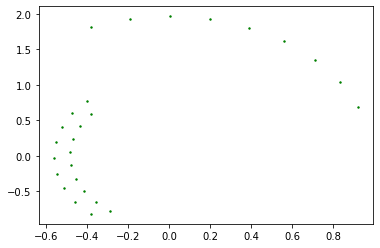

In [17]:
print(trajectories[-3:])

plt.scatter(trajectories[-3:, :,0], trajectories[-3:, :,1], s = 2, color = c)
plt.show()

## N-Dimensional HMC

Now it is extended to N dimensions, in 2 dimensions we have (q0, p0) and (q1, p1) so for example we can plot (q0, q1) and see if the reconstruction by HMC can reproduce. Algorithm is almost identical

In [125]:
import numpy as np
from numpy import linalg as LA
import random
import scipy.stats as st
from scipy.stats import norm
import scipy.integrate as integ
import matplotlib.pyplot as plt
from tqdm import tqdm

def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def func(a):
    x = a[0]
    y = a[1]
    mean = [1,3]
    sigma = 0.5
    norm_x = np.sqrt((x - mean[0])**2 + (y - mean[1])**2)
    g1 = np.exp(-norm_x**2 / (2 * sigma**2)) / np.sqrt((2*np.pi)**2 * sigma**2)

    mean = [1,1]
    sigma = 0.5
    norm_x = np.sqrt((x - mean[0])**2 + (y - mean[1])**2)
    g2 = np.exp(-norm_x**2 / (2 * sigma**2)) / np.sqrt((2*np.pi)**2 * sigma**2)

    mean = [3,3]
    sigma = 0.25
    norm_x = np.sqrt((x - mean[0])**2 + (y - mean[1])**2)
    g3 = np.exp(-norm_x**2 / (2 * sigma**2)) / np.sqrt((2*np.pi)**2 * sigma**2)    
    return g1 + g2 + 5*g3

def leapfrog_step_old(q1, p1, step_size, epsilon):
    q_epsilon = np.zeros(len(q1))
    q_epsilon += epsilon
    dVdQ_1 = (-1*np.log(func(q1 + q_epsilon)) + np.log(func(q1)))/epsilon   #First gradient (ref https://www.jarad.me/courses/stat615/slides/Hierarchical/Hierarchical5.pdf)
    p1 -= step_size*dVdQ_1/2 # as potential energy increases, kinetic energy decreases, half-step
    q1 += step_size*p1 # position increases as function of momentum 
    
    dVdQ_2 = (-1*np.log(func(q1 + q_epsilon)) + np.log(func(q1)))/epsilon 
    p1 -= step_size*dVdQ_2/2 # second half-step "leapfrog" update to momentum 
    return q1, p1

def leapfrog_step(q1, p1, step_size, epsilon, func):
    
    grad_func = []
    for i in range(len(q1)):
        epsilon_vec = np.zeros(len(q1))
        epsilon_vec[i] = epsilon
               
        A_2 = func(q1 + epsilon_vec)
        A_1 = func(q1)

        grad_func.append(-(A_2 - A_1) / (epsilon * A_1))
    
    dVdQ_1 = np.array(grad_func)
#   dVdQ_1 = (-1*np.log(func(q1 + epsilon)) + np.log(func(q1)))/epsilon   #First gradient (ref https://www.jarad.me/courses/stat615/slides/Hierarchical/Hierarchical5.pdf)
    p1 -= step_size * dVdQ_1/2 # as potential energy increases, kinetic energy decreases, half-step
    q1 += step_size * p1 # position increases as function of momentum 

    grad_func = []
    for i in range(len(q1)):
        epsilon_vec = np.zeros(len(q1))
        epsilon_vec[i] = epsilon
               
        A_2 = func(q1 + epsilon_vec)
        A_1 = func(q1)

        grad_func.append(-(A_2 - A_1) / (epsilon * A_1))
        
#   dVdQ_2 = (-1*np.log(func(q1 + epsilon)) + np.log(func(q1)))/epsilon 
    dVdQ_2 = np.array(grad_func)
    p1 -= step_size * dVdQ_2/2 # second half-step "leapfrog" update to momentum 
    return q1, p1

def metropolis_acceptance(q0, p0, q1, p1):
    q0_nlp = func(q0)
    q1_nlp = func(q1)

    p0_nlp = normal(x=p0,mu=0,sigma=1)
    p1_nlp = normal(x=p1,mu=0,sigma=1)

    target = q1_nlp/q0_nlp # P(q1)/P(q0)
    adjustment = p1_nlp/p0_nlp # P(p1)/P(p0)
    acceptance = target*adjustment
    
    event = random.uniform(0,0.5)
    return np.all(event <= acceptance)

def HMC(initial_position,path_len=.8,step_size=0.1, epsilon = 0.01, epochs=1000):
    dimensions = len(initial_position)
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    momentum_dist = st.norm(0, 1.2)
    samples = [initial_position]
    trajectories = []
    success = [] 
    # generate samples
    for e in tqdm(range(epochs)):
        q0 = np.copy(samples[-1])   #np array N-dim
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs(size=dimensions)  #np array N-dim       
        p1 = np.copy(p0) 
        traj = [[q0, p0]]
        dVdQ = np.zeros(dimensions)   #np array N-dim
        
        # leapfrog integration 
        for s in range(steps): 
            q1, p1 = leapfrog_step(q1, p1, step_size, epsilon, func)
            traj.append(np.array([q1, p1]))  
        
        #flip momentum for reversibility 
        p1 = -1*p1     
        trajectories.append(traj)
        
        #metropolis acceptance
        accepted = metropolis_acceptance(q0, p0, q1, p1)
        
        #Decide acceptance or refusal
        if accepted:
            samples.append(q1)
            success.append(True)
        else:
            samples.append(q0)
            success.append(False)
    
    return np.array(samples[1:]), np.array(trajectories), np.array(success)

### Test

In [124]:
epochs = 10
path_len = .8
step_size = 0.1
epsilon = 0.01

trial, trajectories, success = HMC([0.1, 0.1], path_len = .8, step_size = .1, epsilon = .01, epochs = epochs)

100%|██████████| 10/10 [00:00<00:00, 202.21it/s]

dv1 [-3.64485361 -3.64485577] dv2 [-3.90016551 -2.94095358]
dv1 [-3.90016551 -2.94095358] dv2 [-3.99374259 -2.1216539 ]
dv1 [-3.99374259 -2.1216539 ] dv2 [-3.92125737 -1.22310015]
dv1 [-3.92125737 -1.22310015] dv2 [-3.68606317 -0.28447446]
dv1 [-3.68606317 -0.28447446] dv2 [-3.2989823   0.64954315]
dv1 [-3.2989823   0.64954315] dv2 [-2.77763231  1.50579706]
dv1 [-2.77763231  1.50579706] dv2 [-2.14536161  2.07901422]
dv1 [-2.14536161  2.07901422] dv2 [-1.42990164  1.82280992]
dv1 [-1.42990164  1.82280992] dv2 [-1.38019402  1.82523732]
dv1 [-1.38019402  1.82523732] dv2 [-1.27458389  1.91046864]
dv1 [-1.27458389  1.91046864] dv2 [-1.11751753  2.03529638]
dv1 [-1.11751753  2.03529638] dv2 [-0.91557471  2.11997284]
dv1 [-0.91557471  2.11997284] dv2 [-0.67715746  2.07771258]
dv1 [-0.67715746  2.07771258] dv2 [-0.41210187  1.86235256]
dv1 [-0.41210187  1.86235256] dv2 [-0.13123703  1.48716532]
dv1 [-0.13123703  1.48716532] dv2 [0.15408372 0.99805251]
dv1 [0.15408372 0.99805251] dv2 [0.3375765

The last N points sampled can be visualized here:

Rate of accepted trajectories: 9214/10000 = 0.9214


(-4.0, 8.0)

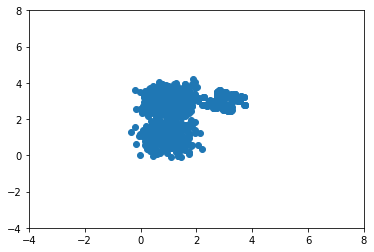

In [118]:
accepted = np.sum(success)
print('Rate of accepted trajectories: {}/{} = {}'.format(accepted, epochs, accepted/epochs))

n_samples = 1000
fig = plt.figure()
last_trial = trial[len(trial)-n_samples:]
x = last_trial[:,0]
y = last_trial[:,1]

n_bins = 50
hist, xedges, yedges = np.histogram2d(x, y, bins= n_bins)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()

z = np.reshape(hist.ravel(), (n_bins, n_bins))
xmin = np.min(xedges)
xmax = np.max(xedges)
ymin = np.min(yedges) 
ymax = np.max(yedges)

#im = plt.imshow(z, cmap = 'Reds', extent = [xmin, xmax, ymin, ymax], aspect = 1)
#plt.colorbar(im)
plt.scatter(x, y)
plt.xlim([-4, 8])
plt.ylim([-4, 8])

### Plot
plot a comparison between the original landscape and the reconstructed one with monte carlo. 
ONLY AVAILABLE FOR DIMENSIONS = 2

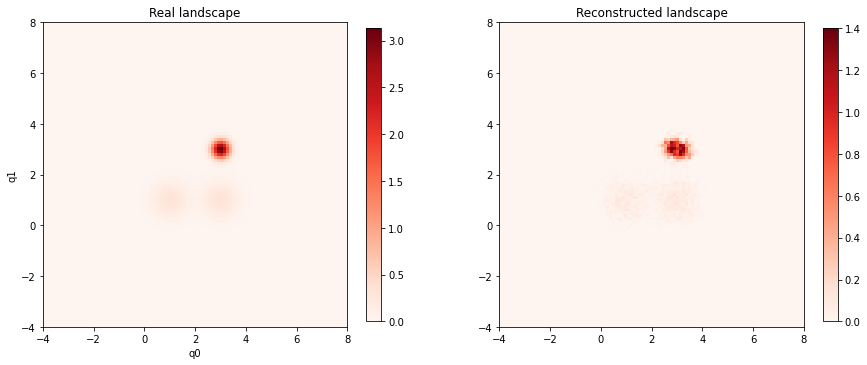

In [119]:
%matplotlib inline

trial = np.array(trial)
lines = np.linspace(-4,8,1000)

trial_accepted = trial[success == True]

#3d plots of the reconstructed landscape
if 0:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x = trial_accepted[:,0]
    y = trial_accepted[:,1]

    hist, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[-4, 8], [-4, 8]])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

    plt.show()
    
#2d plots
if True:
    #------------ FIRST PLOT ------------------#
    x = np.linspace(-4, 8, 100)
    y = np.linspace(-4, 8, 100)

    X, Y = np.meshgrid(x, y)

    Z1 = []
    for x0 in x:
        for y0 in y:
            Z1.append(func([x0, y0]))

    Z = np.array(Z1).reshape((len(x), len(y)))

    fig, axes = plt.subplots(1, 2, figsize = (15, 9))
    ax1 = axes[0]
    ax2 = axes[1]

    ax1.set_xlabel('q0')
    ax1.set_ylabel('q1')
    
    #CS = ax1.contour(X, Y, Z, cmap = 'Blues')
    #ax1.clabel(CS, levels = [.12, .24, .3], inline=True, fontsize=10)
    
    im = ax1.imshow(Z, cmap = 'Reds', extent = [-4, 8, -4, 8], origin = 'lower', aspect = 1)
    ax1.set_title('Real landscape'.format(how_many_traj))
    plt.colorbar(im, ax = ax1, shrink = .6)
    
    #------------ SECOND PLOT ------------------#
    x = trial_accepted[:,0]
    y = trial_accepted[:,1]

    hist,_,_ = np.histogram2d(x, y, bins=100, range=[[-4, 8], [-4, 8]], density = True)
    z = np.reshape(hist.ravel(), (100,100))
    im2 = ax2.imshow(z, cmap = 'Reds', extent = [-4, 8, -4, 8], origin = 'lower', aspect = 1)
    plt.title('Reconstructed landscape')
    plt.colorbar(im2, ax = ax2, shrink = .6)